## Evaluation and Calibration of the Empirical Models in TELL

This notebook is meant to be a landing page for exploring the empirical models that underpin `tell`. It will set up the meteorological variables we use and analyze different aspects of the model development and evaluation.

In [1]:
# Start by importing the TELL package and information about your operating system:
import os 
import tell


In [2]:
# Identify the current working directory, the "tell_data" directory where the data will is stored, and the image output directory:
current_dir =  os.path.join(os.path.dirname(os.getcwd()))
tell_data_dir = os.path.join(current_dir, r'tell_data')
tell_image_dir = os.path.join(tell_data_dir, r'outputs', r'visualizations', r'mlp_evaluation')

# If the "tell_image_dir" subdirectory doesn't exist then create it:
if not os.path.exists(tell_image_dir):
   os.makedirs(tell_image_dir)

### Variable Correlations

The first thing we'll look at is the relationship between the predictive variables in `tell` and the historical electricity demand for different Balancing Authorities (BAs). The function below plots the correlation between the different variables in the historical observed data that underpins `tell`. In general, demand is fairly well correlated with most of the meteorological variables, with the strongest dependency being on 2-m air temperature (T2). The stength of the correlations varies significantly from BA-to-BA. Demand in some BAs is closely tied to variations in weather (e.g., NEVP, ERCO, FPL). In more moderate climates (e.g., SCL, BPAT) the relationships are weaker. This pattern is useful for interpreting the performance of the empircal models in `tell`.

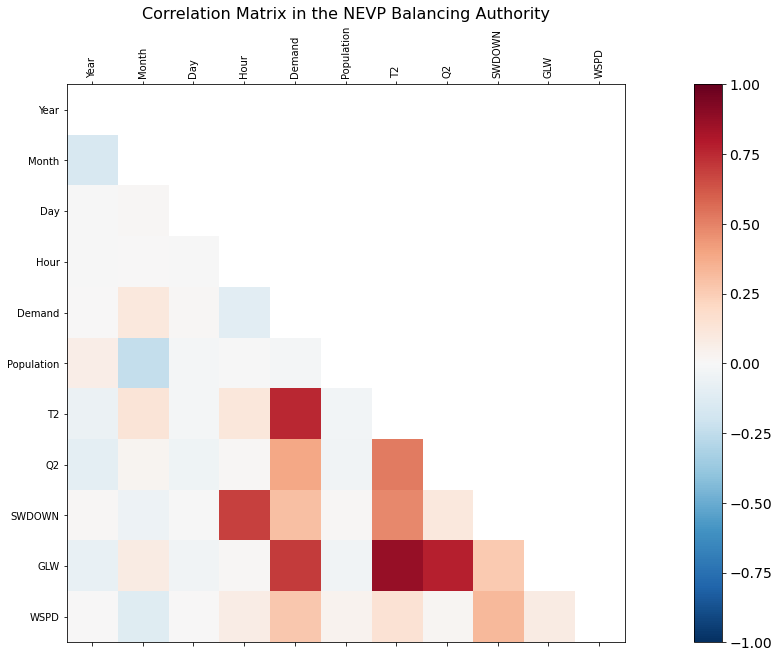

In [3]:
# Plot the correlation between predictive variables in TELL and the historical demand in a given BA. Note that if you set the 'ba_to_plot' variable to "All" the function 
# will compute and plot the average correlation across all BAs:
tell.plot_ba_variable_correlations(ba_to_plot = 'NEVP', 
                                   data_input_dir = tell_data_dir,
                                   image_output_dir = tell_image_dir,
                                   image_resolution = 150,
                                   save_images = True)


### Empirical Model Training

Next we'll train the `tell` models using the standard settings found in the `mlp_settings.yml` file. By default, the `tell` multi-layer perceptron (MLP) models are trained on historical weather and load data from 2016-2018 and evaluated using data from 2019. In addition to the MLP models, `tell` trains a linear model for each BA that uses the hourly evolution of total population within the BA's service territory to predict the residuals from the MLP models. The quantitative effect of these linar models is evaluated later in the notebook.

In [4]:
# Train the empirical models using the standard settings:
prediction_df, validation_df = tell.train_batch(target_region_list = (tell.get_balancing_authority_to_model_dict().keys()),
                                                data_dir = os.path.join(tell_data_dir, r'outputs', r'compiled_historical_data'),
                                                n_jobs = -1)
        
# View the validation dataframe that contains error statistics for the trained models:
validation_df


,BA,RMS_ABS,RMS_NORM,MAPE,R2
0,AEC,61.689522,0.115040,0.098978,0.785859
0,AECI,256.488543,0.095706,0.083492,0.813510
0,AVA,144.075189,0.097853,0.093364,0.735292
0,AZPS,209.238291,0.061818,0.045435,0.955771
0,BANC,116.116706,0.060998,0.044625,0.915132
0,BPAT,295.141606,0.046288,0.035834,0.891834
0,CHPD,28.013047,0.133194,0.087172,0.769089
0,CISO,1915.455279,0.078322,0.057289,0.821470
0,CPLE,506.092038,0.071481,0.054557,0.892236
0,DOPD,21.460967,0.104002,0.093407,0.727292


### Empirical Model Evaluation

After training the models, we'll visualize their performance by plotting the error characteristics for each of the BAs in `tell`. In general, the default training settings results in models that perform quite well. 76% (41/54) of the BAs have an R2 value greater than 0.75 while 89% (48/54) have a MAPE under 10%.

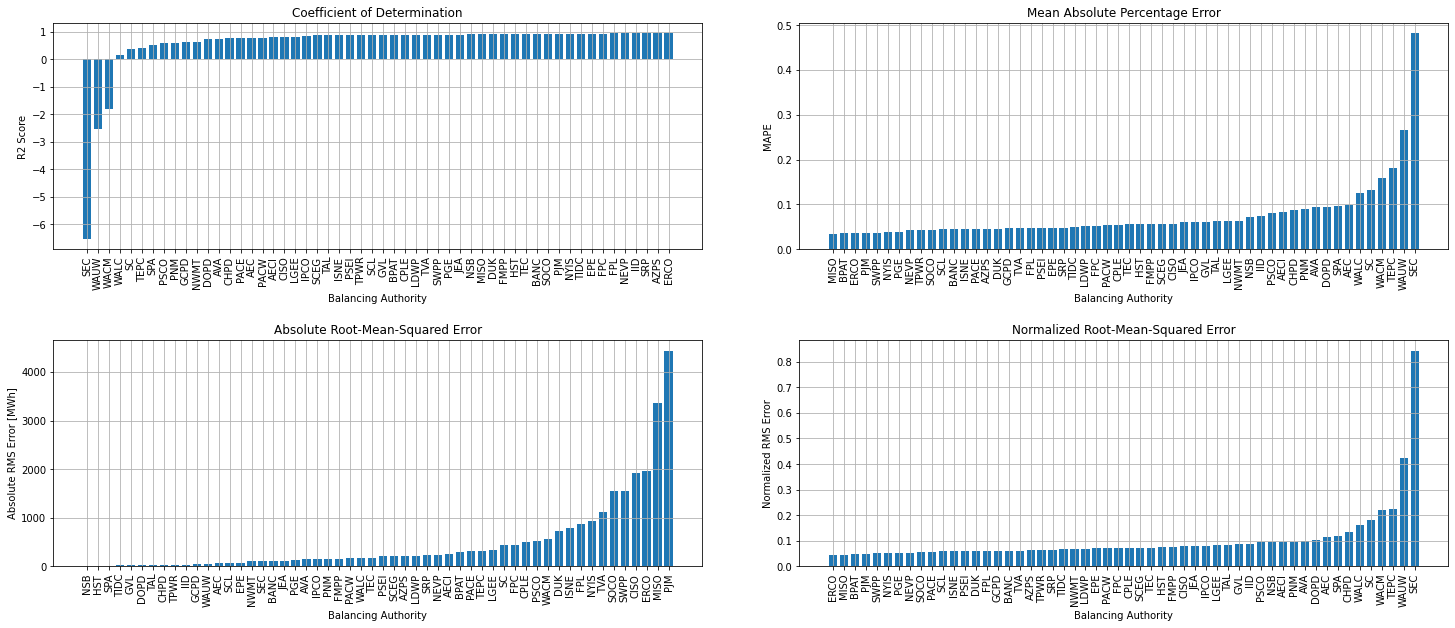

In [5]:
# Plot the statistical performance (e.g., RMS_ABS, RMS_NORM, MAPE, or R2) of the predictive models across all the BAs in TELL:
tell.plot_mlp_summary_statistics(validation_df, 
                                 image_output_dir = tell_image_dir,
                                 image_resolution = 150,
                                 save_images = True)


It's illustrative to look at the error metrics as a function of load. To do this, we calculate the mean hourly load for each BA during the evaluation year and then plot the error statistics as a function of that mean load. Analyzing the data in this way demonstrates that the BAs with the poorly performing emprical models are almost universally the smaller BAs. The largest BAs, which are critically important for the overall demand on the grid, generally perform quite well. Of the 10 BAs with the largest mean demand, 9/10 have a MAPE value under 5% and an R2 value greater than 0.85. Conversely, of the 10 worst performing BAs (judged by their MAPE value), 7/10 have an average hourly load less than 1200 MWh.

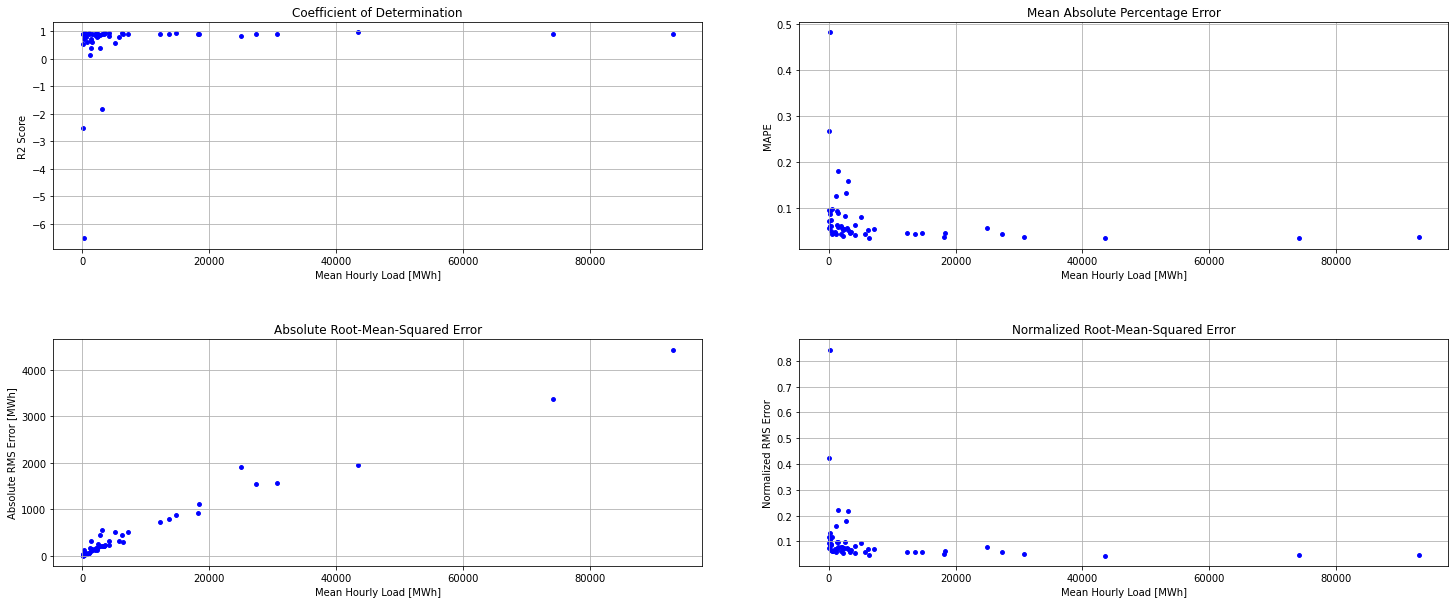

In [6]:
# Plot the statistical performance (e.g., RMS_ABS, RMS_NORM, MAPE, or R2) of the predictive models as a function of mean load for each BA and update the validation dataframe:
validation_df = tell.plot_mlp_errors_vs_load(prediction_df, 
                                             validation_df, 
                                             image_output_dir = tell_image_dir,
                                             image_resolution = 150,
                                             save_images = True)


In [7]:
validation_df.sort_values(by='Mean_Load_MWh', ascending=False).head(10)

,BA,RMS_ABS,RMS_NORM,MAPE,R2,Mean_Load_MWh
33,PJM,4438.988447,0.048589,0.036654,0.917614,93021.998885
25,MISO,3369.169622,0.045440,0.034560,0.905095,74100.506253
12,ERCO,1961.564482,0.044788,0.036081,0.956714,43479.571456
44,SWPP,1557.759063,0.050634,0.037038,0.899050,30723.822113
41,SOCO,1543.124172,0.056684,0.043245,0.916689,27358.328600
7,CISO,1915.455279,0.078322,0.057289,0.821470,24958.385640
50,TVA,1109.950988,0.061026,0.046401,0.898547,18342.497131
29,NYIS,926.480013,0.052080,0.038473,0.918724,18177.380761
15,FPL,879.507297,0.060074,0.046937,0.940211,14665.992829
21,ISNE,791.794795,0.058639,0.044869,0.886545,13685.300927


In [8]:
validation_df.sort_values(by='MAPE', ascending=False).head(10)

,BA,RMS_ABS,RMS_NORM,MAPE,R2,Mean_Load_MWh
40,SEC,113.717765,0.843874,0.481402,-6.531780,199.082966
53,WAUW,39.759954,0.422524,0.266865,-2.534615,129.473674
47,TEPC,320.602492,0.223051,0.181890,0.399069,1410.741493
51,WACM,564.196463,0.218648,0.158598,-1.818936,3042.231939
37,SC,441.914633,0.180152,0.132554,0.390608,2739.596600
52,WALC,174.218896,0.160383,0.126203,0.148799,1175.039890
0,AEC,61.689522,0.115040,0.098978,0.785859,497.089418
42,SPA,8.747627,0.117097,0.096778,0.520957,73.713564
9,DOPD,21.460967,0.104002,0.093407,0.727292,192.404493
2,AVA,144.075189,0.097853,0.093364,0.735292,1383.679452


The next set of plots analyzes the predicted and observed demands for individual BAs in order to shed more light on the performance of the `tell` empirical models. The first function plots the time-series and histograms of observed and predicted demands for a given BA. Using this function you can see the strong performance of `tell` in larger BAs (e.g., PJM, MISO, ERCO). They also shed some clues into the poor performance in smaller BAs. For example, the data from SEC shows bad observations that weren't caught by the data cleanining functions that are ran before the MLP models are trained. Despite its poor performance, the small loads present in SEC allow us to retain the model for that BA even though it is poor without impacting the overall fidelity of `tell`.

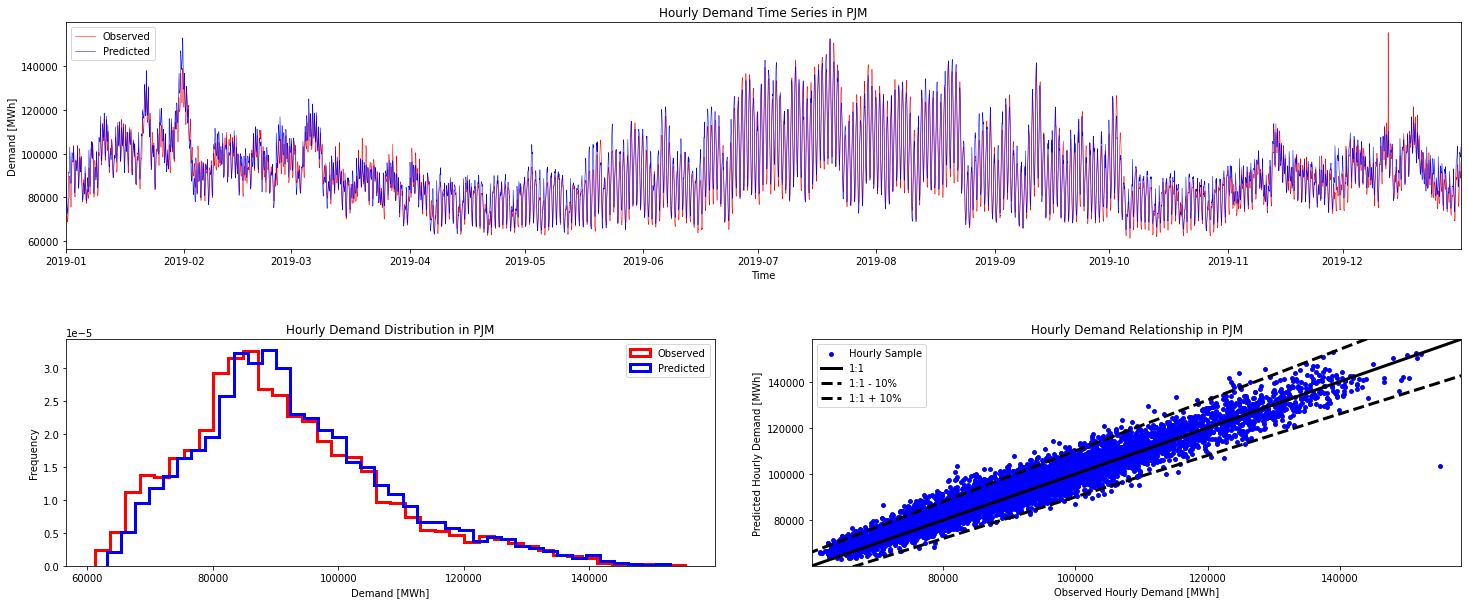

In [9]:
tell.plot_mlp_ba_time_series(prediction_df, 
                             ba_to_plot = 'PJM',
                             image_output_dir = tell_image_dir,
                             image_resolution = 150,
                             save_images = True)


Next let's take a look at the performance of the `tell` empirical models during the peak week of demand during the evaluation period. To find the peak demand week we compute a weekly rolling mean value of predicted demand using exponentially-weighted windows and then subset the data to +/- 3.5 days around the peak value. This analysis can be used to understand how well `tell` is capturing peak loads.

/Users/burl878/Documents/tell/tell/tell/visualization.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['Rolling_Mean'] = subset_df['predictions'].ewm(span=168).mean()


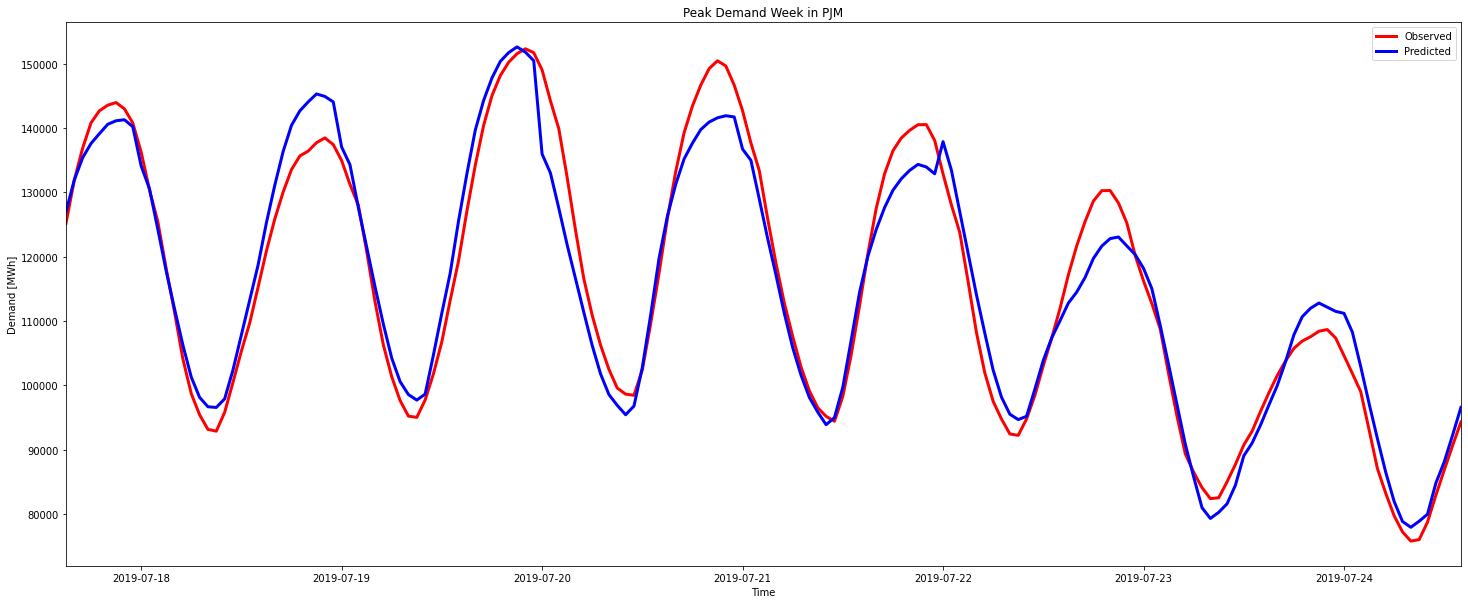

In [10]:
tell.plot_mlp_ba_peak_week(prediction_df, 
                           ba_to_plot = 'PJM',
                           image_output_dir = tell_image_dir,
                           image_resolution = 150,
                           save_images = True)


### Impact of the Supplemental Linear Model

The final thing we'll explore is the impact of training a linear model on the residuals of the MLP models in `tell`. This was done because population within the BAs evolves on an annual scale as opposed to hourly like the meteorological variables and thus population is rarely selected as a strong predictor in the MLP models. Nonetheless, we know that the gradual evolution of population within a BA can impact the evolution of demand. In this final section of the notebooks we retrain the `tell` empirical models without invoking the linear model adjustment step (i.e., `mlp_linear_adjustment = False`). In most BAs the models with the linear adjustment perform slightly better than those without. This shows up most clearly in the MAPE value plotted below.

In [11]:
prediction_df_nolinear, validation_df_nolinear = tell.train_batch(target_region_list = (tell.get_balancing_authority_to_model_dict().keys()),
                                                                  mlp_linear_adjustment = False,
                                                                  data_dir = os.path.join(tell_data_dir, r'outputs', r'compiled_historical_data'),
                                                                  n_jobs = -1)

validation_df_nolinear

,BA,RMS_ABS,RMS_NORM,MAPE,R2
0,AEC,49.211245,0.091770,0.072805,0.866857
0,AECI,358.228996,0.133670,0.137694,0.637289
0,AVA,153.252524,0.104086,0.100846,0.703339
0,AZPS,218.702652,0.064614,0.048553,0.951582
0,BANC,113.222460,0.059478,0.043038,0.917731
0,BPAT,293.592680,0.046045,0.035538,0.894621
0,CHPD,28.540442,0.135701,0.083801,0.772396
0,CISO,2098.321811,0.085799,0.062476,0.783569
0,CPLE,545.175783,0.077002,0.059833,0.876389
0,DOPD,30.427879,0.147456,0.153519,0.474521


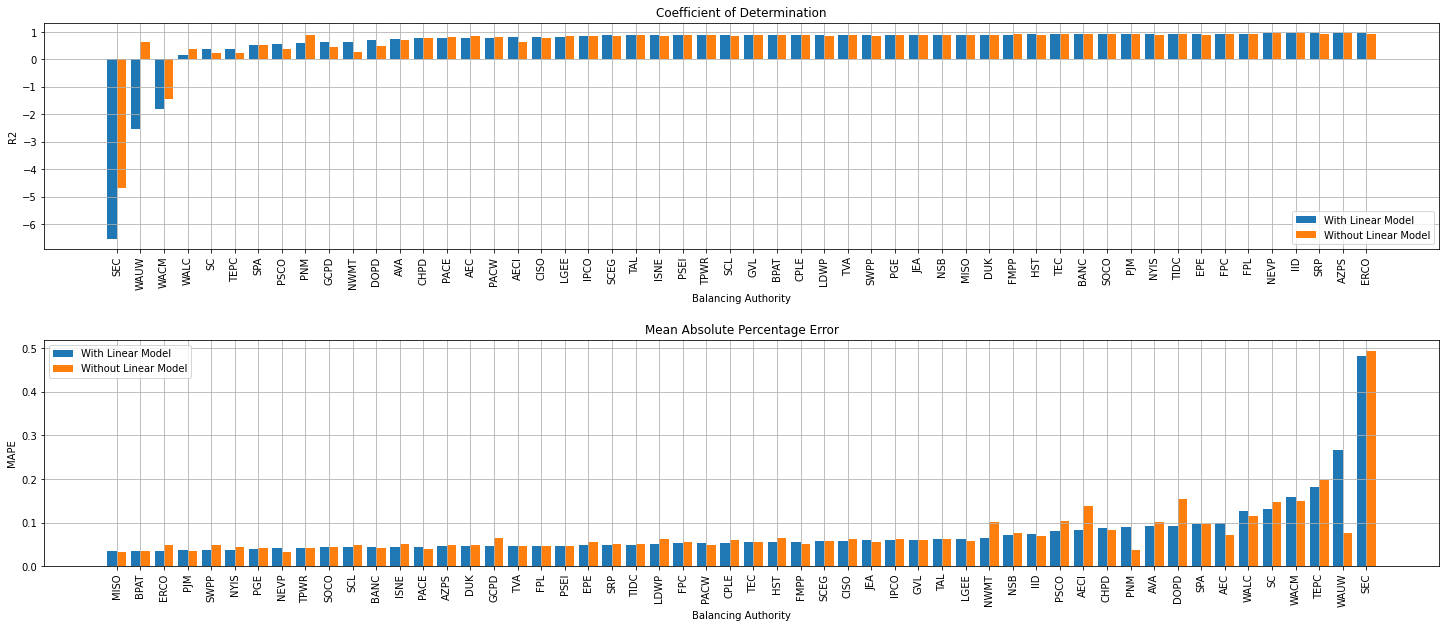

In [12]:
# Plot the R2 and MAPE score for each BA using the validation_df for the models with and without the linear adjustment step:
impact_df = tell.plot_mlp_linear_model_impact(validation_df, 
                                              validation_df_nolinear,
                                              image_output_dir = tell_image_dir,
                                              image_resolution = 150,
                                              save_images = True)
